<a href="https://colab.research.google.com/github/ElwinGao4444/colab/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numpy

In [ ]:
import numpy as np

In [ ]:
print('arange: ', np.arange(0, 10, 2, dtype=int))
print('random: \n', np.random.rand(3, 2))
print('reshape: \n', np.arange(9).reshape(3,3))

arange:  [0 2 4 6 8]
random: 
 [[0.5753019  0.9604517 ]
 [0.21214062 0.10491335]
 [0.91404834 0.09215131]]
reshape: 
 [[0 1 2]
 [3 4 5]
 [6 7 8]]


# Pandas

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
print('Series: \n', pd.Series(['a','b','c']))
print('DataFrame: \n', pd.DataFrame(np.arange(9).reshape(3,3), columns=['c0','c1','c2'], index=['r0','r1','r2']))

Series: 
 0    a
1    b
2    c
dtype: object
DataFrame: 
     c0  c1  c2
r0   0   1   2
r1   3   4   5
r2   6   7   8


# Matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

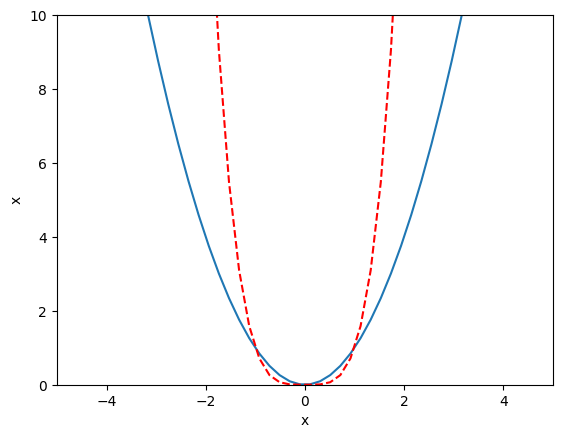

In [ ]:
x = np.linspace(-5,5,50)
y1 = x**2
y2 = x**4
plt.gca().set(xlabel='x', ylabel='x', xlim=[-5, 5], ylim=[0, 10])
plt.plot(x, y1, label = 'Y1')
plt.plot(x, y2, label = 'Y2', color='red', ls='dashed')

# Tensorflow

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## 一个简单的模型示例

In [ ]:
# model可以直接作为函数使用
# 当如此使用的时候，它就是在求解Sequential所代表的复合函数
# 对于一个输出长度为1的Dense层来说，它所表达的就是求解多元线性函数
model = tf.keras.Sequential() # 定义一个Sequential模型
model.add(tf.keras.layers.Dense(1,  # 输出向量长度为1的线性函数
                kernel_initializer=tf.keras.initializers.Ones(),  # w系数初始化为全1
                bias_initializer=tf.keras.initializers.Ones(),   # b系数初始化为1
                ))  # Dense层在被首次使用的时候，会动态适配输入参数的元数
model(tf.constant([[1]])) # 1个样本，每个样本元数为1，也就是最常见的y=wx+b

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.]], dtype=float32)>

## 一个简单的模型训练

In [ ]:
# 加载数据集
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# 定义模型

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

# 模型(model)可以简单的理解为一个复合函数，参数就是自变量(向量)集合，返回值就是对应的y值集合
predictions = model(x_train[:1])    # 输入位1个28x28的数据，输出为1个size为10的一维向量
tf.nn.softmax(predictions).numpy()  # 将model输出的向量，进行softmax操作，转化为相加为1的概率

array([[0.10536896, 0.07058986, 0.07537115, 0.11808683, 0.0754171 ,
        0.0993856 , 0.11890236, 0.04115049, 0.12448064, 0.17124699]],
      dtype=float32)

In [ ]:
# 不在model里增加一个softmax层，而是使用SparseCategoricalCrossentropy的from_logits参数
# 主要原因就是softmax做指数运算，交叉熵做对数运算，二者合并运算，可以简化计算，并防止数值越界
# 自己做softmax，然后令from_logits=False(默认为False)，可得到相同的计算结果
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(y_train[:1], predictions).numpy()

2.3087478

### Keras封装版

In [ ]:
# 通过compile指定损失函数，优化器
# metrics=['accuracy'] 指定要为模型评估的指标
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [ ]:
# 执行训练过程
model.fit(x_train, y_train, epochs=1)

1875/1875 [==============================] - 10s 5ms/step - loss: 0.2997 - accuracy: 0.9130


In [ ]:
# 检查模型性能
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.1425 - accuracy: 0.9574 - 641ms/epoch - 2ms/step


[0.14248539507389069, 0.9574000239372253]

### 手写版

In [ ]:
# 定义训练步骤
batch_size = 32

def train(x, y, model, loss_fn, trainer):
    counter = 0
    data = (x, y)
    train_iter = tf.data.Dataset.from_tensor_slices(data).batch(batch_size).shuffle(len(data[0]))
    for x, y in train_iter:
        counter = counter + 1
        with tf.GradientTape() as tape:
            y_hat = model(x)
            l = loss_fn(y, y_hat)
            params = model.trainable_variables
            grads = tape.gradient(l, params)
            trainer.apply_gradients(zip(grads, params))
            print('\r', end='')
            print('train loss[%d]: %s' % (counter, l), end='')
    return l

In [ ]:
# 执行训练过程
trainer = tf.keras.optimizers.Adam()
train(x_train[:3200], y_train[:3200], model, loss_fn, trainer)

train loss[100]: tf.Tensor(0.19496962, shape=(), dtype=float32)

<tf.Tensor: shape=(), dtype=float32, numpy=0.19496962>

In [ ]:
# 使用测试集进行验证
def predict(model, x, y):
    y_hat = tf.argmax(model(x), axis=1).numpy()
    right = np.count_nonzero(y==y_hat)
    return right / len(y)
predict(model, x_test[:3200], y_test[:3200])

0.89

# PIL

In [ ]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# PIL用法

url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_(test_image).png'
response = requests.get(url, stream=True, verify=True)
img = Image.open(BytesIO(response.content))

img_gray = img.convert('L')
img_pixel = img_gray.load()
img_array = np.array(img_gray)
# plt.imshow(img_array, cmap='gray')

# OpenCV

In [ ]:
import cv2
import requests
import matplotlib.pyplot as plt

In [ ]:
# OpenCV 从图片加载数据
def download_image_file_from_url(name, url):
    response = requests.get(url, stream=True, verify=True)
    with open(name,'wb') as f:
        f.write(response.content)

download_image_file_from_url('img.png', 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_(test_image).png')
img = cv2.imread('img.png')

In [ ]:
# OpenCV 从URL加载数据
def get_image_from_url(url):
    img_array = np.array(bytearray(requests.get(url, stream=True, verify=True).content), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
img = get_image_from_url('https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_(test_image).png')

In [ ]:
# cv2基本用法

url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_(test_image).png'
img_array = np.array(bytearray(requests.get(url, stream=True, verify=True).content), dtype=np.uint8)
img = cv2.imdecode(img_array, -1)

# 灰度
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# 高斯滤波 卷积 3 * 3
img_blur = cv2.GaussianBlur(img_gray, (9, 9), 0)
# x梯度
xgrad = cv2.Sobel(img_blur, cv2.CV_16SC1, 1, 0)
# y梯度
ygrad = cv2.Sobel(img_blur, cv2.CV_16SC1, 0, 1)
# 直接使用原图进行边缘检测 阈值 50 ~ 150
edge0 = cv2.Canny(img, 50, 150)
# 使用梯度参数进行边缘检测 阈值 50 ~ 150
edge1 = cv2.Canny(xgrad, ygrad, 50, 150)
# 直接用高斯滤波结果进行边缘检测 阈值 50 ~ 150
edge2 = cv2.Canny(img_blur, 50, 150)

In [ ]:
# 边缘检测

def print_edge(url, threshold1=100, threshold2=200):
    img_array = np.array(bytearray(requests.get(url, stream=True, verify=True).content), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    edge = cv2.Canny(img, threshold1, threshold2)
    plt.imshow(edge, cmap='gray')

url = 'https://img2.baidu.com/it/u=2270678657,833306474&fm=253&fmt=auto&app=120&f=JPEG?w=1422&h=800'
print_edge(url)

# Langchain

In [ ]:
pip install --upgrade --quiet langchain-google-genai pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.2.0 which is incompatible.


In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [ ]:
llm = ChatGoogleGenerativeAI(
    google_api_key = userdata.get('GOOGLE_API_KEY'),
    model = "gemini-pro",
    # temperature = 0.9,
    # top_k = 1,
    # top_p = 1.0,
    # max_output_tokens = 1024, # 最大输出token数
    )
result = llm.invoke("just one word")
print(result.content)

Sure.


# hugging face

In [ ]:
pip install transformers torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
model_id = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True, padding_side='left')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
input_text = "Who are you?"
input_ids = tokenizer(input_text, return_tensors="pt")
outputs = model.generate(input_ids["input_ids"], max_new_tokens=100)
decoded_outputs = tokenizer.decode(outputs[0])
print(decoded_outputs)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Who are you? What are you doing here?

The man looked at her with a mixture of surprise and suspicion. He was a tall, thin man with a scruffy beard and a worn-out coat. He seemed to be in his late thirties, and he had a tired look in his eyes.

"I'm sorry," he said, his voice hoarse. "I didn't mean to scare you. I'm just looking for a place to stay."

Soph


# 临时

In [ ]:
print('hello colab')

hello colab
